In [1]:
import uproot
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import gridspec
import yahist
import itertools
import mplhep as hep

plt.rcParams.update({"figure.facecolor":  (1,1,1,0)})

from utils.analysis import Optimization

TAG = "kscans"

In [2]:
presort_babies = sorted(glob.glob(f"../analysis/studies/vbswh/output_{TAG}/Run2/*.root"))
presort_babies = [baby for baby in presort_babies if "data" not in baby]
presort_babies = [baby for baby in presort_babies if "Lambda" not in baby]
babies = []
for baby in sorted(presort_babies, reverse=True):
    if "EWK" in baby.split("/")[-1]:
        babies.append(baby)
    else:
        babies.insert(0, baby)
        
for baby_i, baby in enumerate(babies):
    if "VBSWH_SM" in baby.split("/")[-1] in baby:
        babies.append(babies.pop(baby_i))
        break
babies

['../analysis/studies/vbswh/output_kscans/Run2/Bosons.root',
 '../analysis/studies/vbswh/output_kscans/Run2/SingleTop.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTX.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar1L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/TTbar2L.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_mkW.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VH.root',
 '../analysis/studies/vbswh/output_kscans/Run2/WJets.root',
 '../analysis/studies/vbswh/output_kscans/Run2/EWKWLep.root',
 '../analysis/studies/vbswh/output_kscans/Run2/VBSWH_SM.root']

In [3]:
vbswh = Optimization(
    sig_root_files=[baby for baby in babies if "VBSWH_mkW" in baby],
    bkg_root_files=[baby for baby in babies if "VBSWH_mkW" not in baby],
    ttree_name="tree",
    weight_columns=[
        "xsec_sf", "lep_id_sf", "ewkfix_sf", 
        "elec_reco_sf", "muon_iso_sf", 
        "btag_sf", "pu_sf", "prefire_sf", "trig_sf"
    ],
    plots_dir=f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt",
    sample_labels = {
        "VBSWH_SM": "VBSWH (SM)", 
        "TTbar1L": r"$t\bar{t}+1\ell$",
        "TTbar2L": r"$t\bar{t}+2\ell$",
        "TTX": r"$t\bar{t}+X$",
        "SingleTop": "Single top",
        "WJets": "W+jets",
        "EWKWLep": r"EWK W$\rightarrow\ell\nu$"
    },
    reweight_column="reweights"
)
vbswh.df["presel_noVBS_noBVeto"] = vbswh.df.eval(
    "hbbjet_score > 0.3"
)
vbswh.df["presel_noVBS"] = vbswh.df.eval(
    "passes_bveto and hbbjet_score > 0.3"
)
vbswh.df["presel_noDetaJJ"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and hbbjet_score > 0.3"
)
vbswh.df["presel"] = vbswh.df.eval(
    "passes_bveto and M_jj > 500 and abs(deta_jj) > 3 and hbbjet_score > 0.3"
)
# vbswh.df["SR"] = vbswh.df.eval(
#     "presel and ST > 1200 and M_jj > 1500 and abs(deta_jj) > 4 and hbbjet_score > 0.9 and hbbjet_msoftdrop < 150"
# )
vbswh.df["SR2"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 1500 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["regionA"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionB"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop >= 150"
)
vbswh.df["regionC"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) <= 4 and hbbjet_msoftdrop < 150"
)
vbswh.df["SR1"] = vbswh.df.eval(
    "presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9 and abs(deta_jj) > 4 and hbbjet_msoftdrop < 150"
)
# vbswh.make_selection("passes_bveto == True")
# vbswh.make_selection("passes_bveto != True")

Loading bkg babies: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 9/9 [00:42<00:00,  4.67s/it]


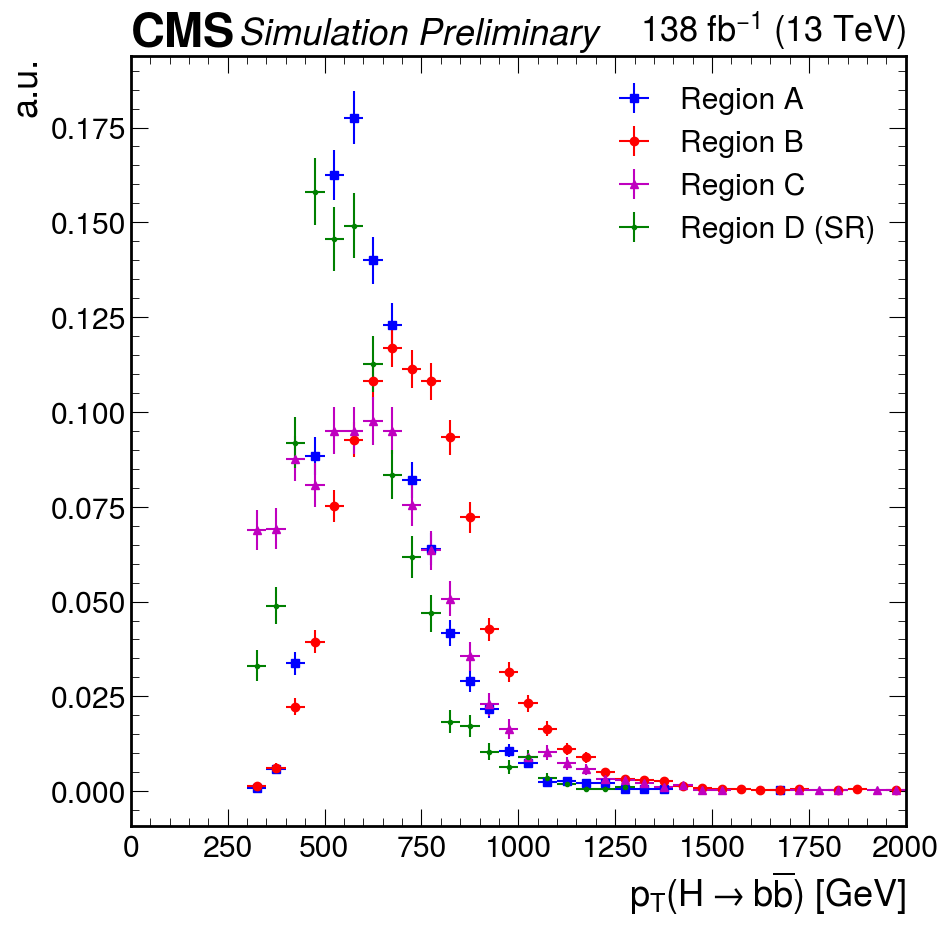

In [4]:
bins = np.linspace(0, 2000, 41)

fig, axes = plt.subplots()

ttbar_df = vbswh.bkg_df(selection="name == 'TTbar1L' or name == 'TTbar2L'")

regionA_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionA].hbbjet_pt.values,
    bins=bins,
    color="b",
    label="Region A"
).normalize()
regionA_hist.plot(ax=axes, errors=True, fmt="s")

regionB_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionB].hbbjet_pt.values,
    bins=bins,
    color="r",
    label="Region B"
).normalize()
regionB_hist.plot(ax=axes, errors=True, fmt="o")

regionC_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.regionC].hbbjet_pt.values,
    bins=bins,
    color="m",
    label="Region C"
).normalize()
regionC_hist.plot(ax=axes, errors=True, fmt="^")

regionD_hist = yahist.Hist1D(
    ttbar_df[ttbar_df.SR1].hbbjet_pt.values,
    bins=bins,
    color="g",
    label="Region D (SR)"
).normalize()
regionD_hist.plot(ax=axes, errors=True, fmt=".")

hep.cms.label("Preliminary", data=False, lumi=138, loc=0, ax=axes)

axes.set_ylabel("a.u.");
axes.set_xlabel(r"$p_T(H\rightarrow b\overline{b})$ [GeV]");

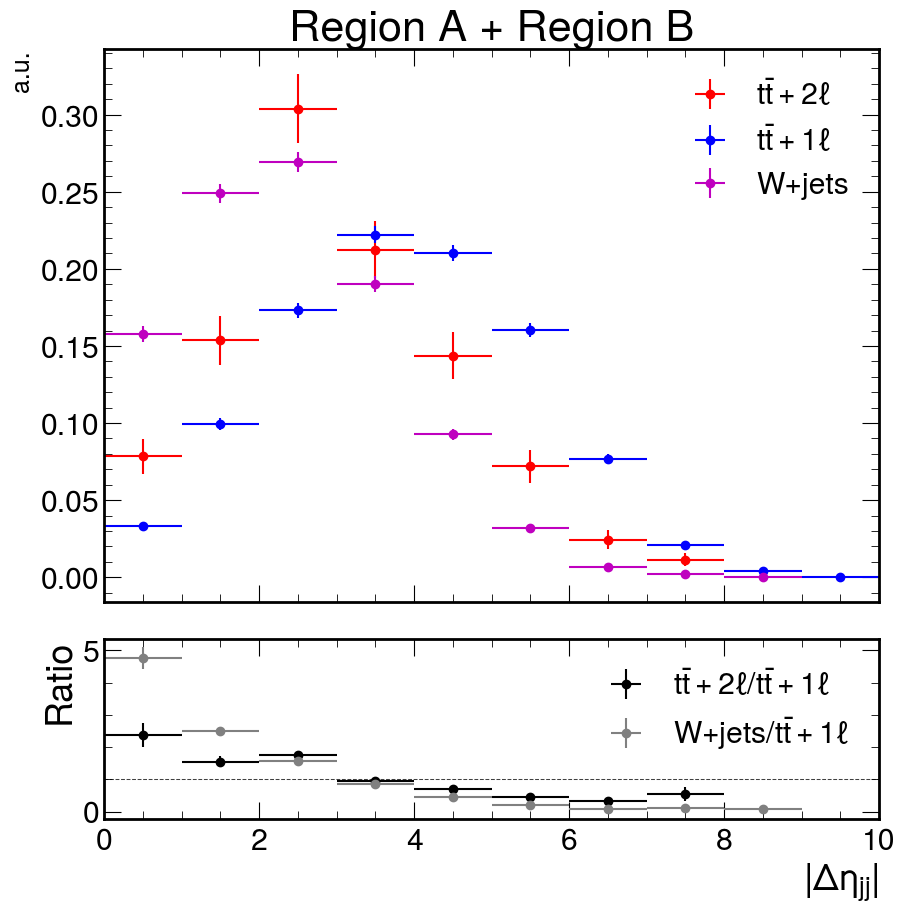

In [5]:
selection = "(regionA or regionB)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region A + Region B");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/AB_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

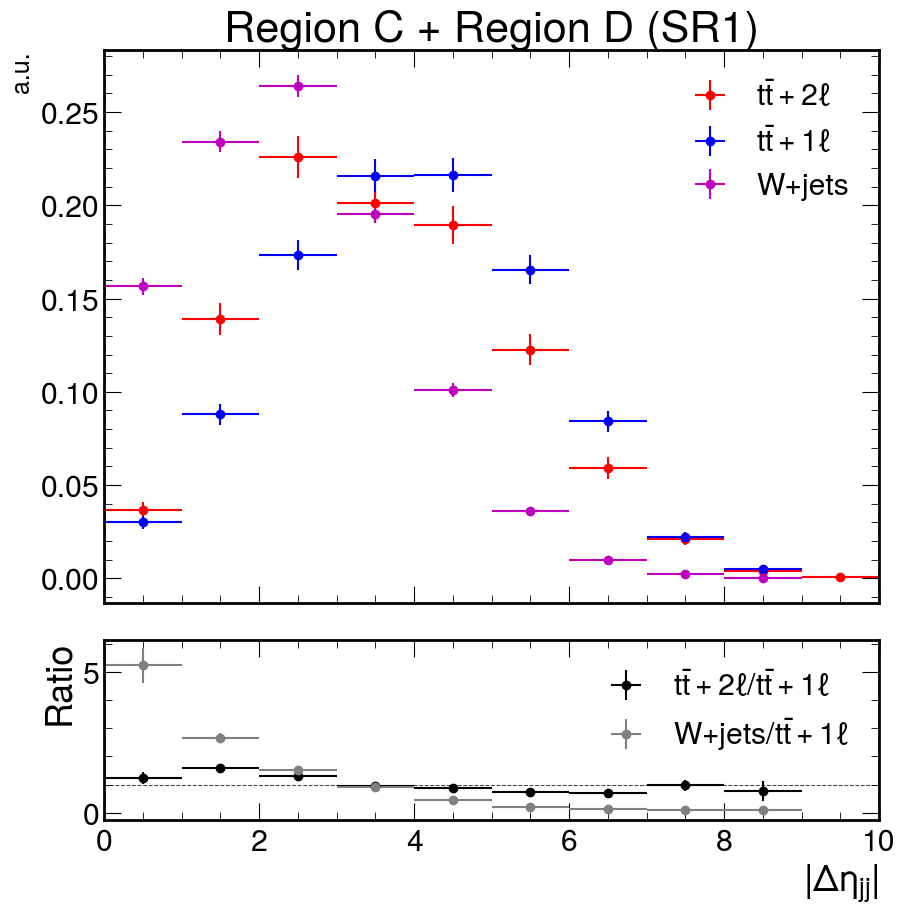

In [6]:
selection = "(regionC or SR1)"
bins = np.linspace(0, 10, 11)

fig = plt.figure()
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig, height_ratios=[2, 0.65], hspace=0.1)
hist_axes = fig.add_subplot(gs[0])
ratio_axes = fig.add_subplot(gs[1])


tt1l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar1L'")
tt2l_df = vbswh.bkg_df(selection=f"{selection} and name == 'TTbar2L'")
wjets_df = vbswh.bkg_df(selection=f"{selection} and name == 'WJets'")

tt1l_hist = yahist.Hist1D(
    np.abs(tt1l_df.deta_jj.values),
    bins=bins,
    color="b",
    label=r"$t\bar{t}+1\ell$"
).normalize()
tt2l_hist = yahist.Hist1D(
    np.abs(tt2l_df.deta_jj.values),
    bins=bins,
    color="r",
    label=r"$t\bar{t}+2\ell$"
).normalize()
wjets_hist = yahist.Hist1D(
    np.abs(wjets_df.deta_jj.values),
    bins=bins,
    color="m",
    label="W+jets"
).normalize()
ratio_hist = tt1l_hist/tt2l_hist

tt2l_hist.plot(ax=hist_axes, errors=True)
tt1l_hist.plot(ax=hist_axes, errors=True)
wjets_hist.plot(ax=hist_axes, errors=True)
(tt2l_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="k", label=r"$t\bar{t}+2\ell/t\bar{t}+1\ell$")
(wjets_hist/tt1l_hist).plot(ax=ratio_axes, errors=True, color="grey", label=r"W+jets$/t\bar{t}+1\ell$")

hist_axes.set_xticklabels([]);
hist_axes.set_ylabel("a.u.", size=18)
hist_axes.set_title("Region C + Region D (SR1)");

ratio_axes.axhline(y=1, color="k", linestyle="--", alpha=0.75, linewidth=0.75)
# ratio_axes.legend().remove()
ratio_axes.set_ylabel("Ratio");
ratio_axes.set_xlabel(r"$|\Delta\eta_{jj}|$");

plot_file = f"/home/users/jguiang/public_html/vbswh_plots/{TAG}/opt/CD_wjets_vs_ttbar.pdf"
plt.savefig(plot_file, bbox_inches="tight")

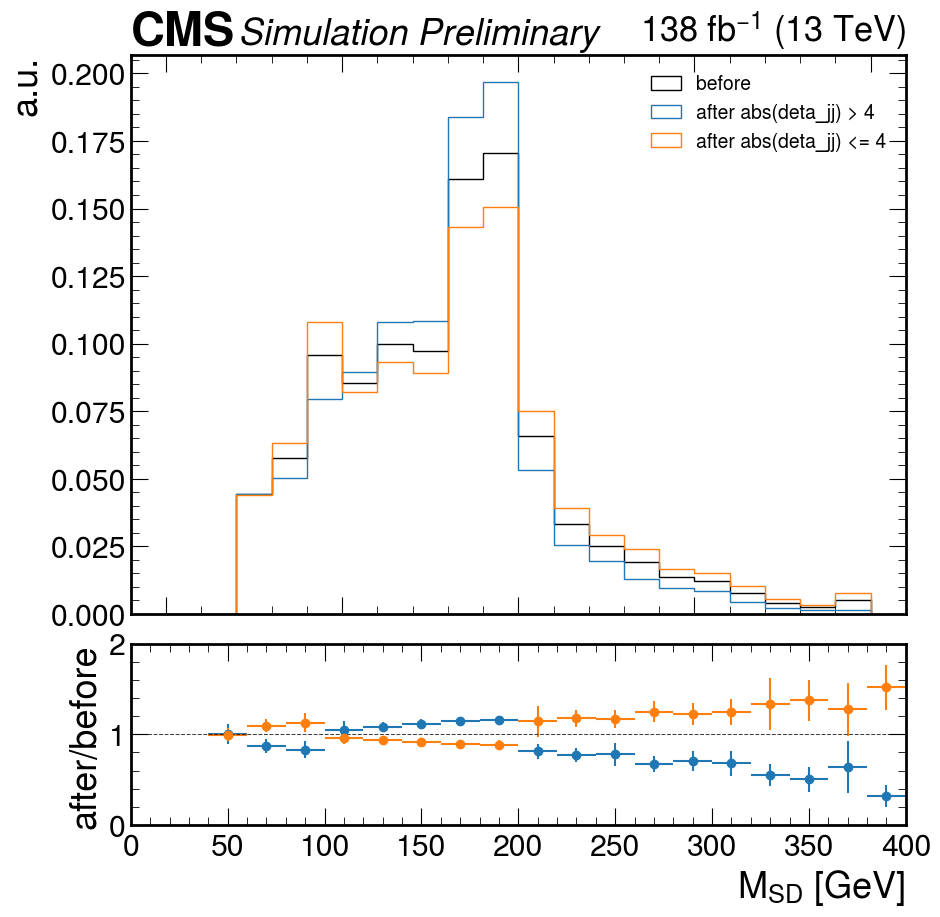

In [7]:
vbswh.plot_correlation(
    "hbbjet_msoftdrop", 
    np.linspace(0, 400, 21), 
    selections=[
        "abs(deta_jj) > 4",
        "abs(deta_jj) <= 4"
    ],
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    x_label="$M_{SD}$ [GeV]",
);

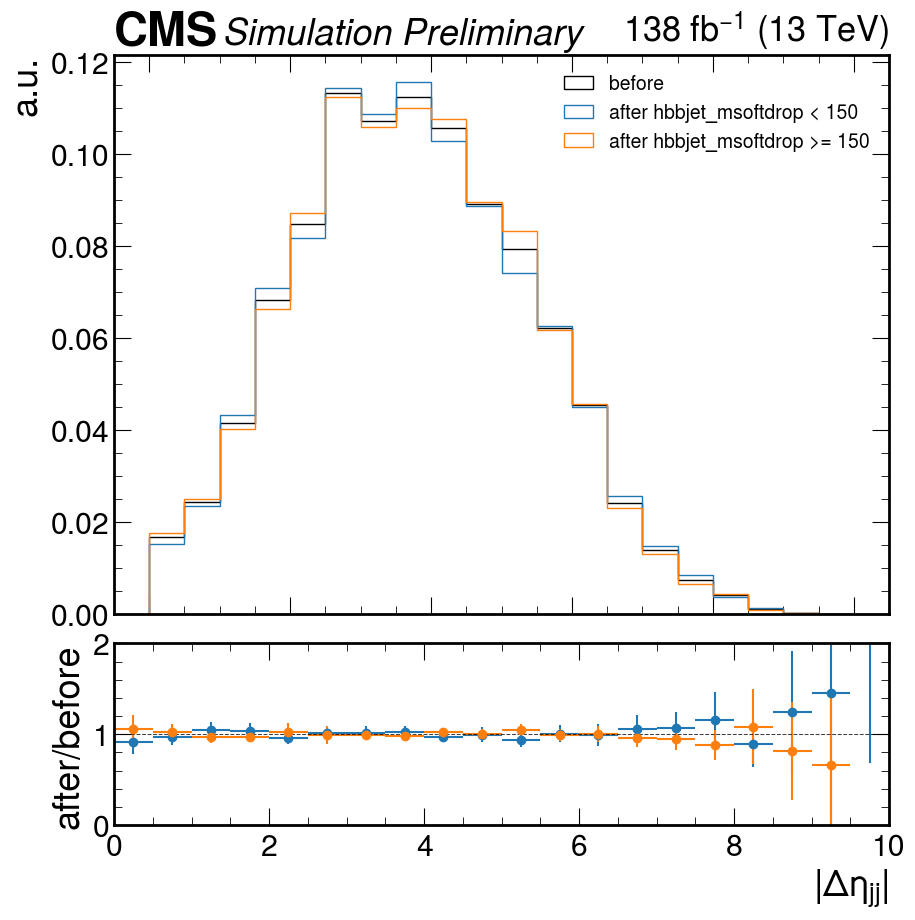

In [8]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 21),  
    selections=[
        "hbbjet_msoftdrop < 150",
        "hbbjet_msoftdrop >= 150"
    ], 
    base_selection="presel_noDetaJJ and M_jj > 600 and ST > 900 and hbbjet_score > 0.9",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

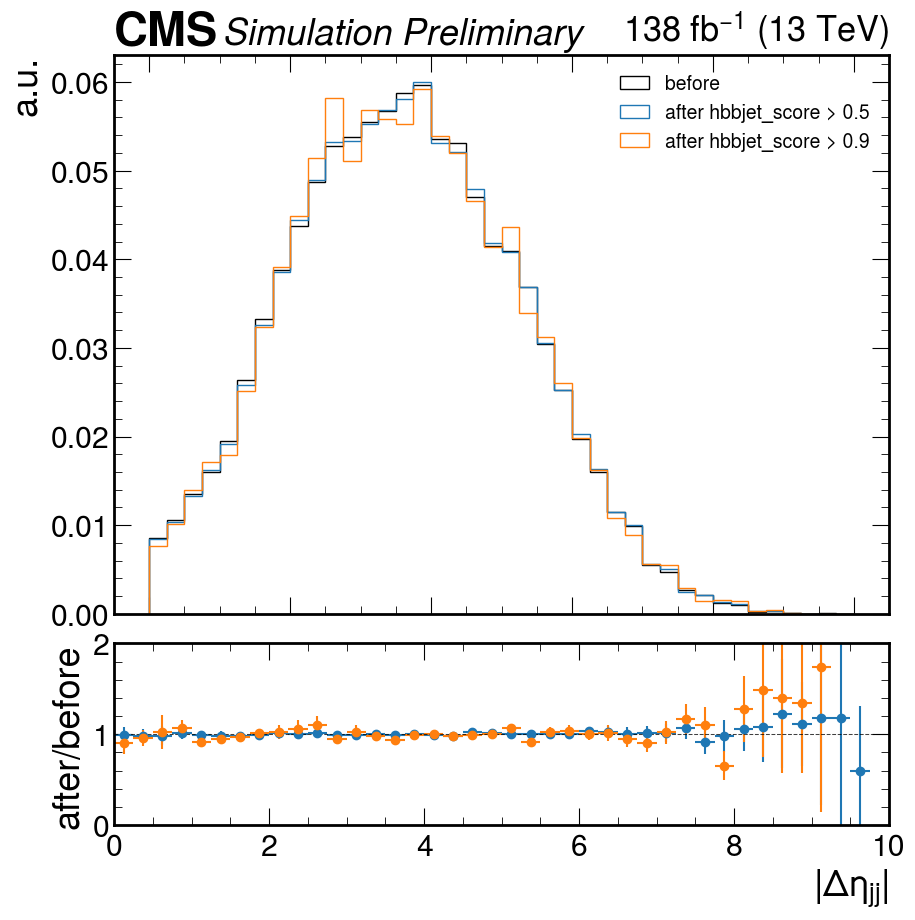

In [9]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "hbbjet_score > 0.5",
        "hbbjet_score > 0.9"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

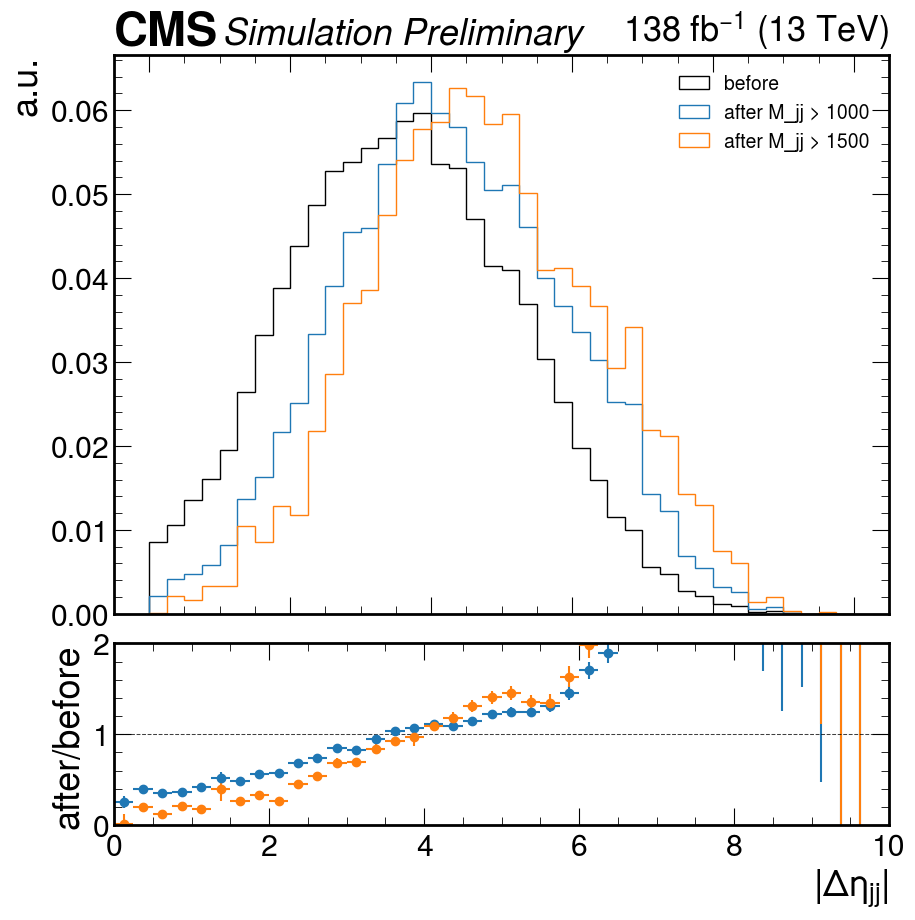

In [10]:
vbswh.plot_correlation(
    "deta_jj", 
    np.linspace(0, 10, 41),  
    selections=[
        "M_jj > 1000",
        "M_jj > 1500"
    ], 
    base_selection="presel_noDetaJJ and hbbjet_msoftdrop >= 150",
    transf=abs,
    x_label=r"$|\Delta\eta_{jj}|$"
);

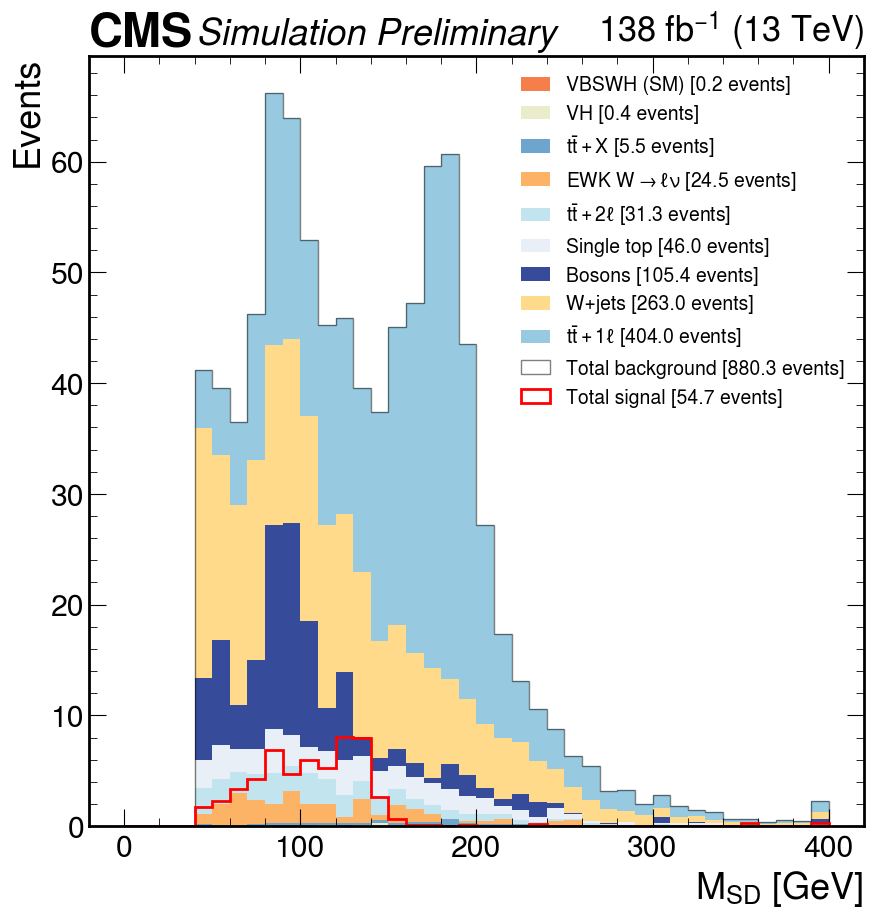

In [11]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel and hbbjet_score < 0.6",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

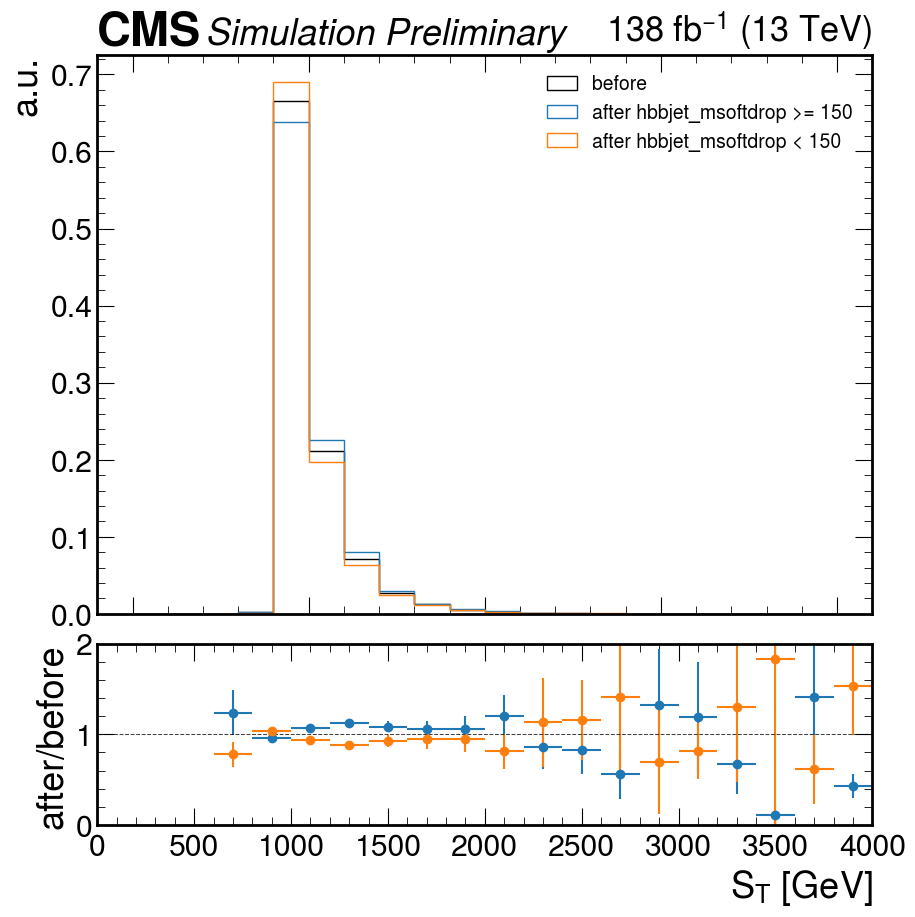

In [12]:
vbswh.plot_correlation(
    "ST", 
    np.linspace(0, 4000, 21),  
    selections=[
        "hbbjet_msoftdrop >= 150",
        "hbbjet_msoftdrop < 150"
    ], 
    base_selection="presel",
    x_label=r"$S_T$ [GeV]"
);

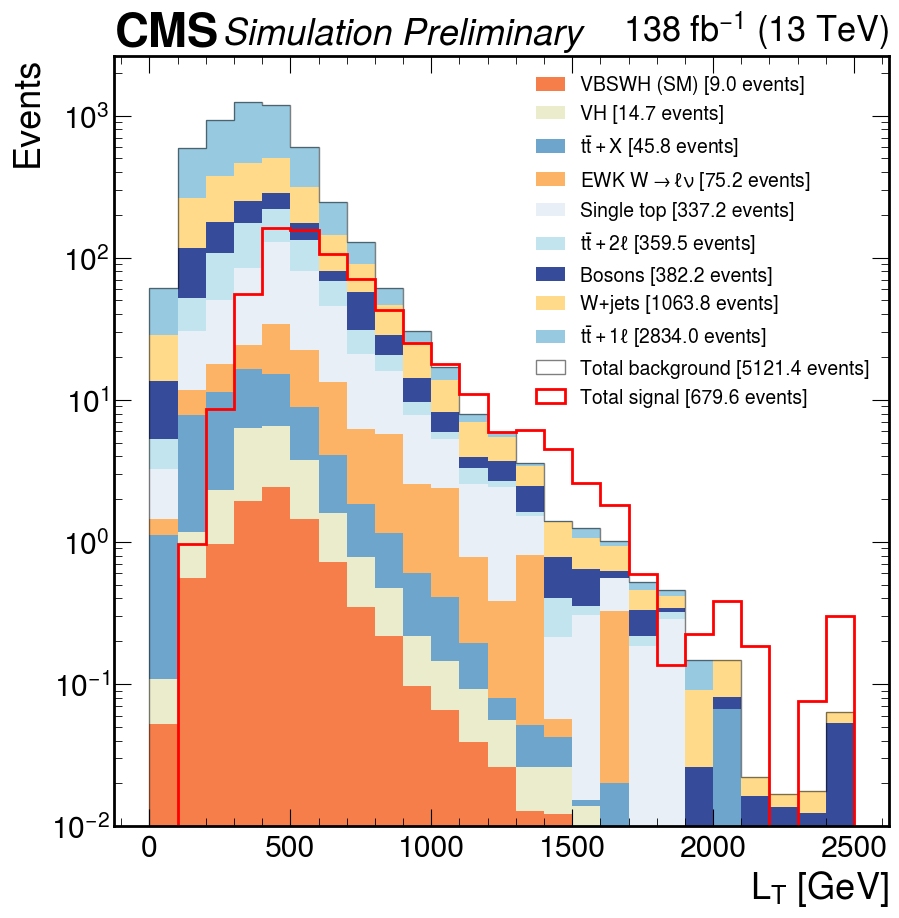

In [13]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 2500, 26), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
    logy=True
);

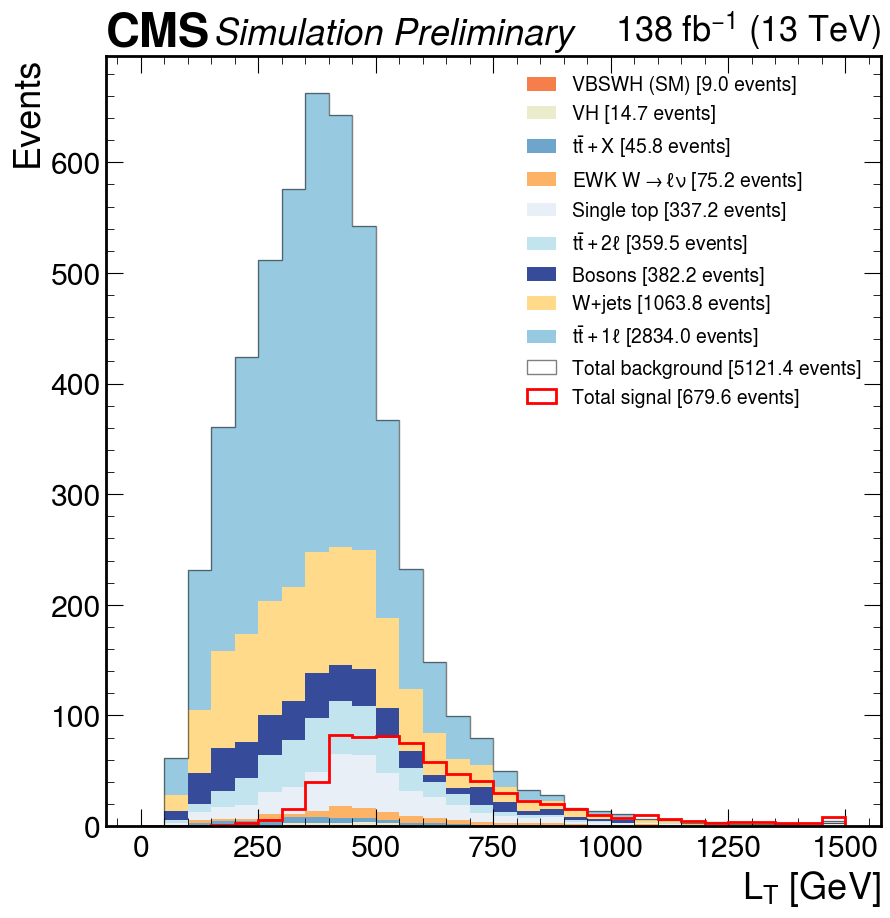

In [14]:
axes = vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1500, 31), 
    selection="presel_noDetaJJ",
    x_label="$L_T$ [GeV]",
    stacked=True,
#     norm=True
);

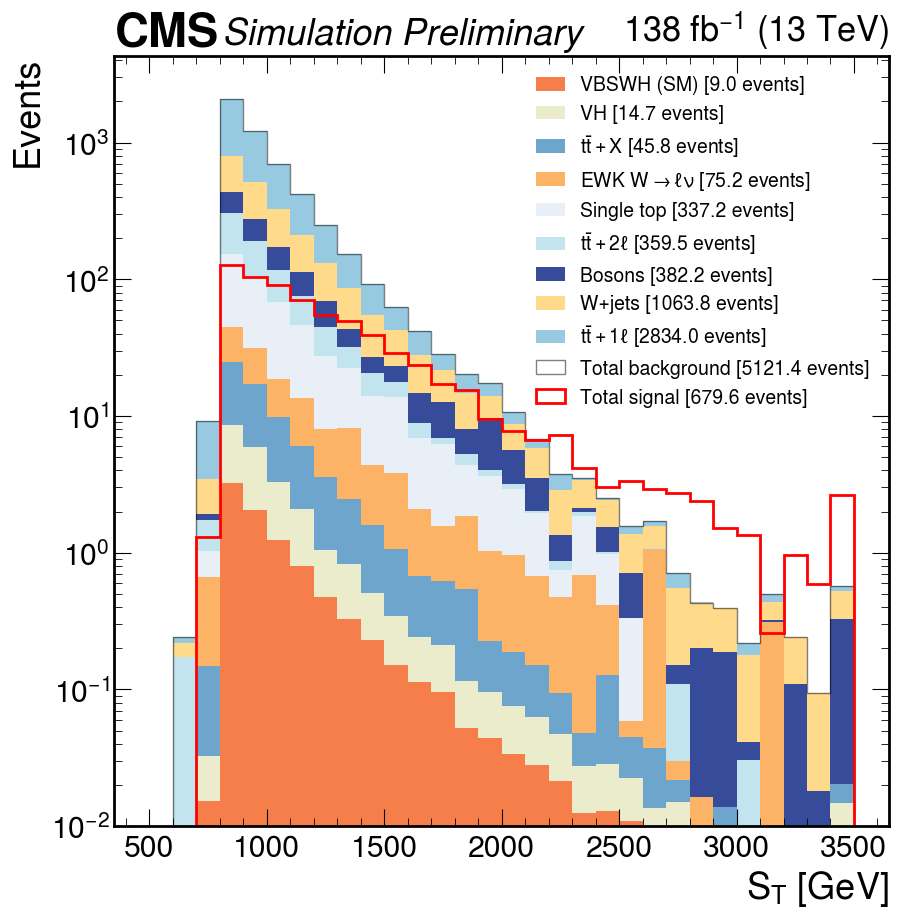

In [15]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 3500, 31), 
    selection="presel_noDetaJJ",
    x_label="$S_T$ [GeV]",
    stacked=True,
    logy=True
);

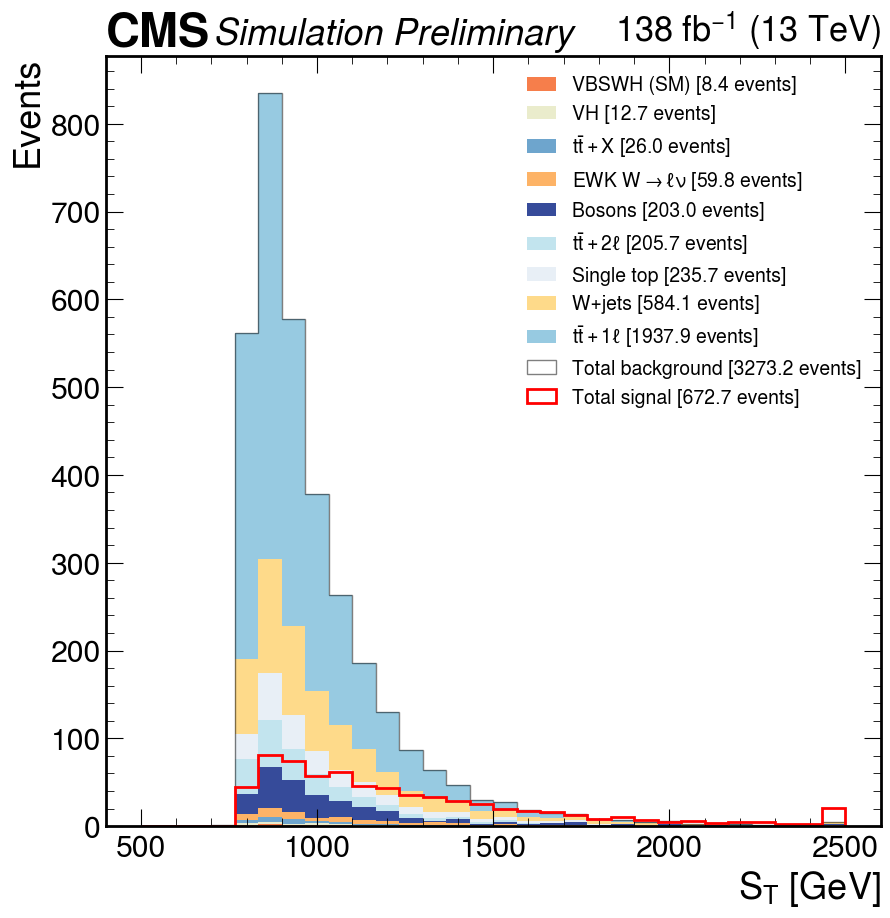

In [16]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(500, 2500, 31), 
    selection="presel",
    x_label="$S_T$ [GeV]",
    stacked=True,
#     logy=True,
#     norm=True
);

In [17]:
vbswh.get_event_counts(selection="presel and hbbjet_msoftdrop >= 150")

(20.517615061337725, 1585.038503526964)

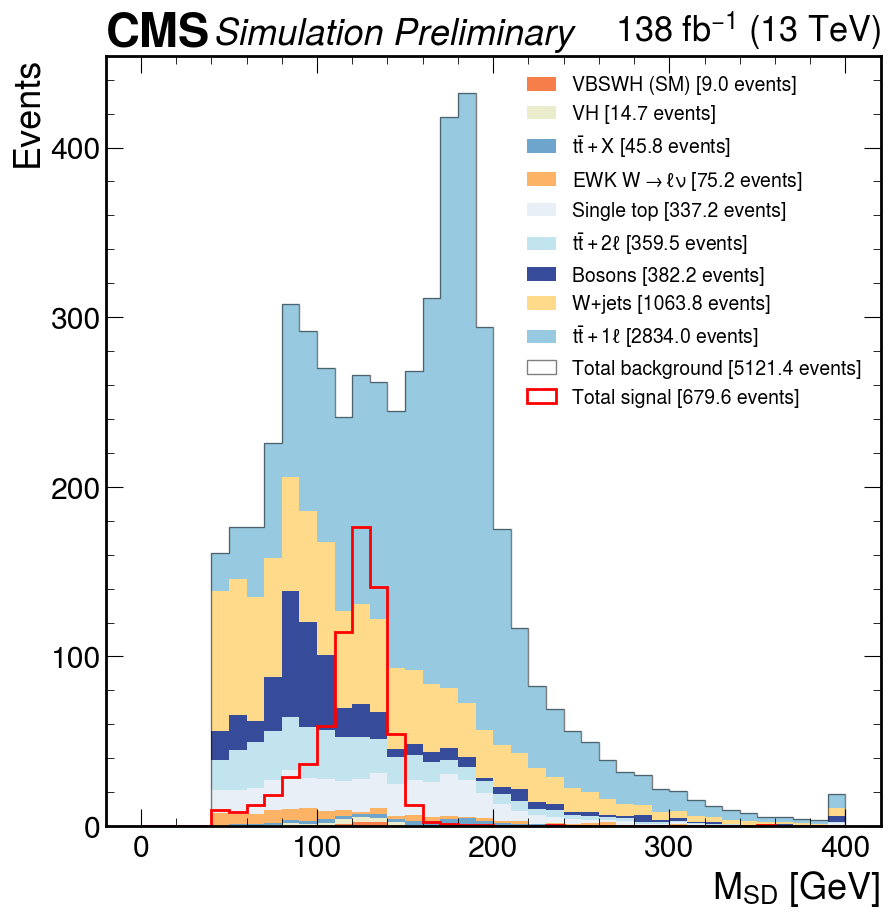

In [18]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_msoftdrop", np.linspace(0, 400, 41), 
    selection="presel_noDetaJJ",
    x_label="$M_{SD}$ [GeV]",
    stacked=True,
#     norm=True
);

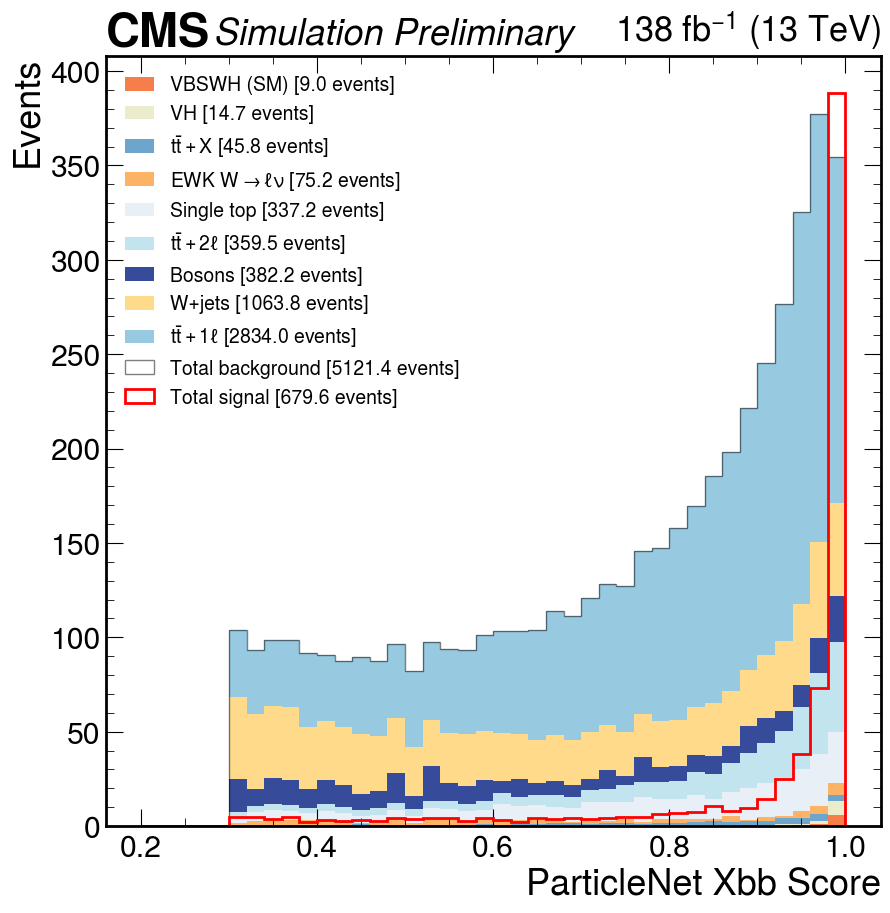

In [19]:
axes = vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0.2, 1, 41), 
    selection="presel_noDetaJJ",
    x_label="ParticleNet Xbb Score",
    stacked=True,
    legend_loc="upper left"
#     norm=True
);

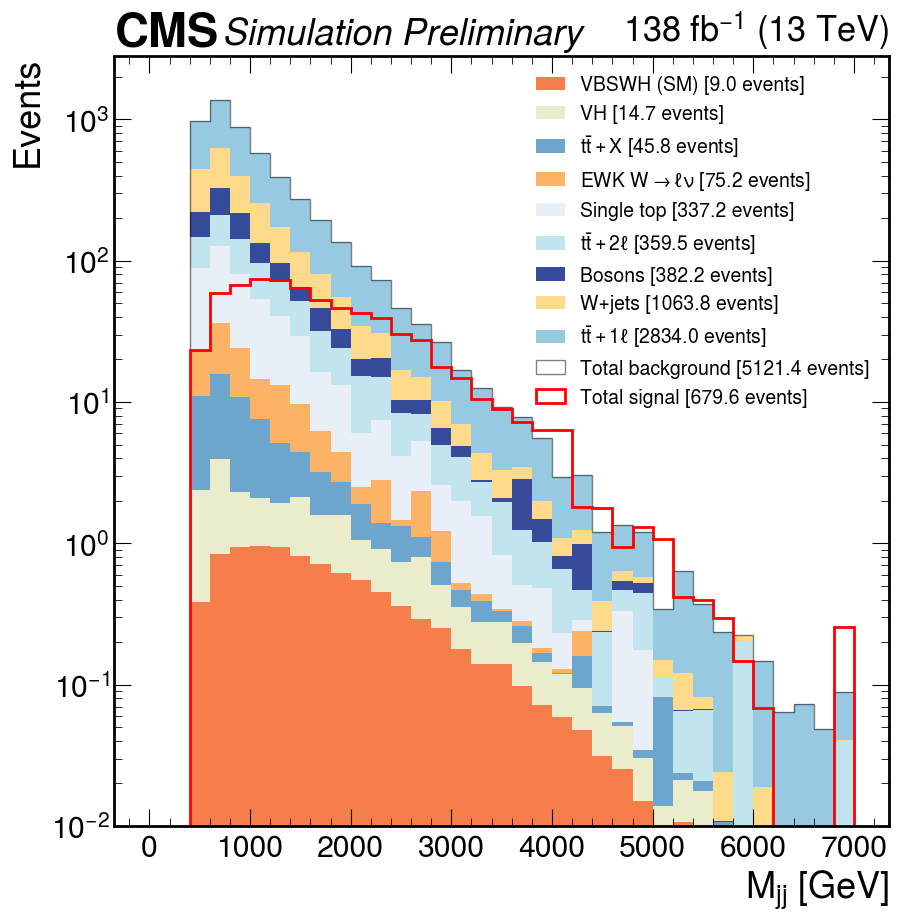

In [20]:
axes = vbswh.plot_sig_vs_bkg(
    "M_jj", np.linspace(0, 7000, 36), 
    selection="presel_noDetaJJ",
    x_label="$M_{jj}$ [GeV]",
    stacked=True,
    logy=True
);

In [21]:
vbswh.get_event_counts(selection="presel_noDetaJJ and abs(deta_jj) <= 3")

(6.884027238822846, 1848.2031608515829)

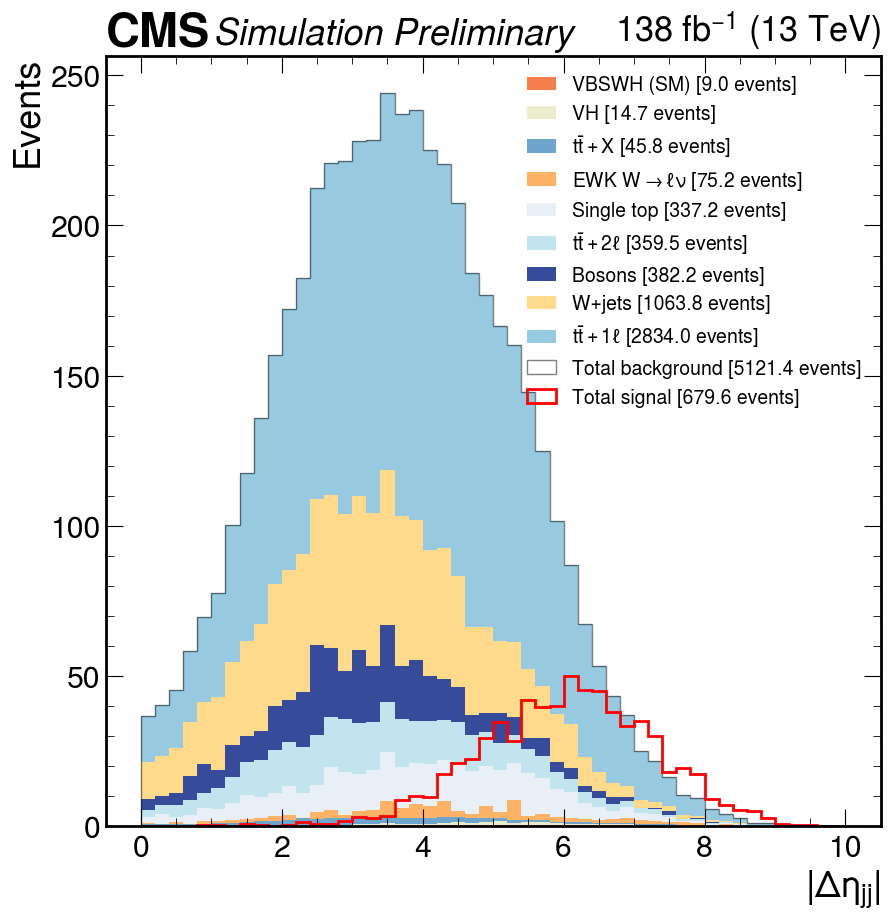

In [22]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(0, 10, 51), 
    selection="presel_noDetaJJ", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

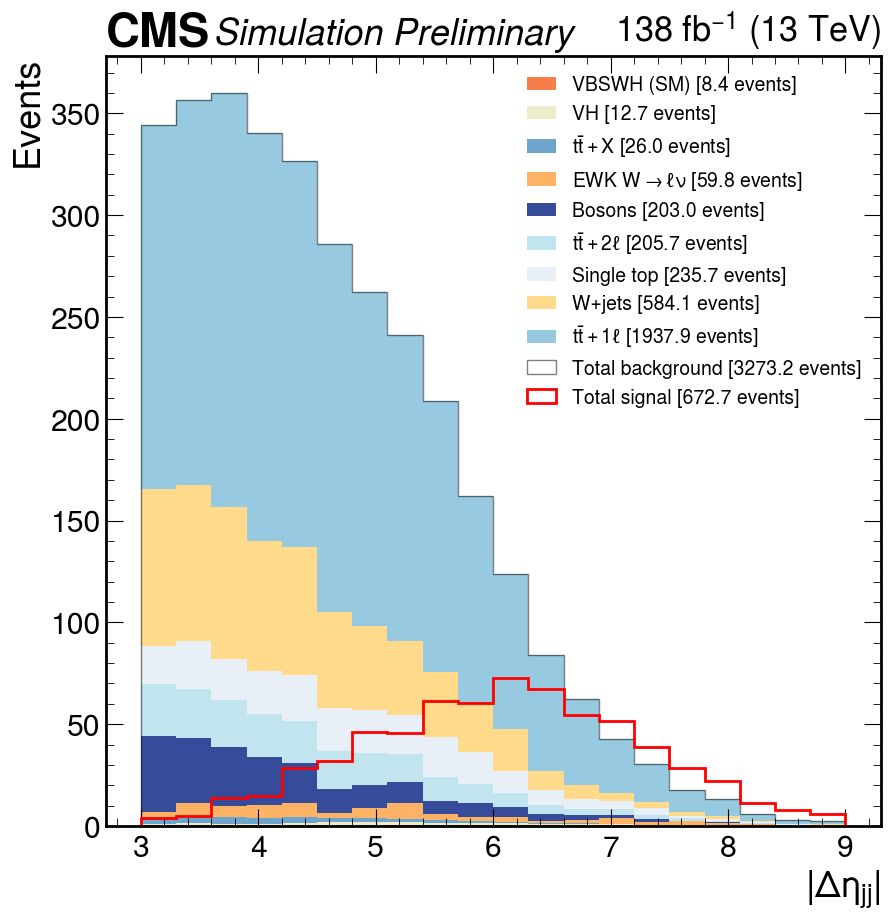

In [23]:
axes = vbswh.plot_sig_vs_bkg(
    "deta_jj", np.linspace(3, 9, 21), 
    selection="presel", 
    x_label="$|\Delta\eta_{jj}|$",
    transf=abs,
    stacked=True
);

In [24]:
vbswh.fom_scan(
    "deta_jj", [3.5, 4, 4.5, 5, 5.5, 6, 6.5, 7], operator=">", 
    base_selection="M_jj > 1500", abs=True
)

sel,sig,bkg,fom
M_jj > 1500,562.0590734119086,5378.785260514643,7.6637240757297045
M_jj > 1500 and abs(deta_jj) > 3.5,560.2206839457662,4221.0368290414535,8.622824930182075
M_jj > 1500 and abs(deta_jj) > 4,556.0599956342211,3706.591474817161,9.133438119209154
M_jj > 1500 and abs(deta_jj) > 4.5,549.2789809776709,3095.273943874717,9.8728703624828
M_jj > 1500 and abs(deta_jj) > 5,528.5043713880859,2408.181228552525,10.769709785877325
M_jj > 1500 and abs(deta_jj) > 5.5,496.97602110688945,1771.9430037000818,11.806211541778358
M_jj > 1500 and abs(deta_jj) > 6,432.2795572730346,1243.599490794842,12.258135854227593
M_jj > 1500 and abs(deta_jj) > 6.5,326.8275549128243,837.7868782368913,11.291506474581142
M_jj > 1500 and abs(deta_jj) > 7,222.14301915919503,509.09509933693687,9.845396519642119


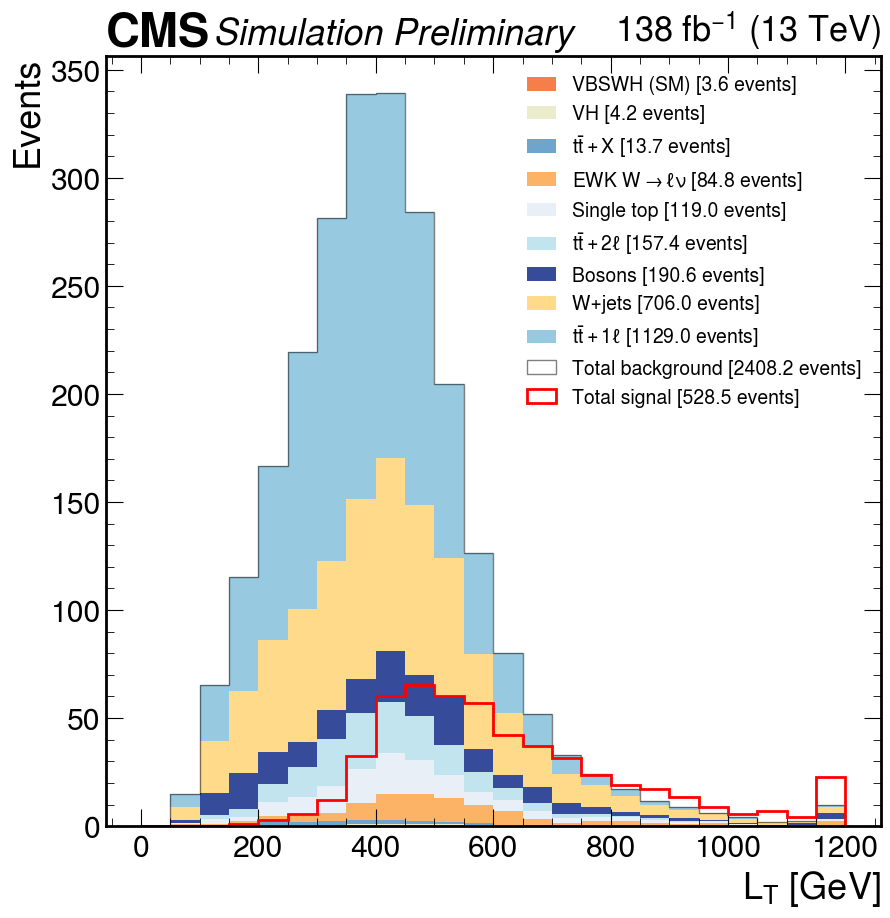

In [25]:
vbswh.plot_sig_vs_bkg(
    "LT", np.linspace(0, 1200, 25), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", 
    x_label="$L_T$ [GeV]",
    stacked=True
);

In [26]:
vbswh.fom_scan(
    "LT", [500, 600, 700, 800, 900, 1000, 1100, 1200], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
);

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,528.5043713880859,2408.181228552525,10.769709785877325
M_jj > 1500 and abs(deta_jj) > 5 and LT > 500,349.5508762231408,581.8260257055578,14.491516084979116
M_jj > 1500 and abs(deta_jj) > 5 and LT > 600,232.51895001607863,250.7970033194473,14.68240439722136
M_jj > 1500 and abs(deta_jj) > 5 and LT > 700,153.48966747412805,118.78181057627381,14.083291702569511
M_jj > 1500 and abs(deta_jj) > 5 and LT > 800,98.0377831959757,61.99436188788101,12.45137707683564
M_jj > 1500 and abs(deta_jj) > 5 and LT > 900,61.64528971670532,33.093465864701045,10.715902944441188
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1000,39.37896257136874,18.12259016672504,9.250264179145347
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1100,26.937456281311604,12.032562563950588,7.76564473463053
M_jj > 1500 and abs(deta_jj) > 5 and LT > 1200,19.084250211920676,7.593599037766188,6.925502193632535


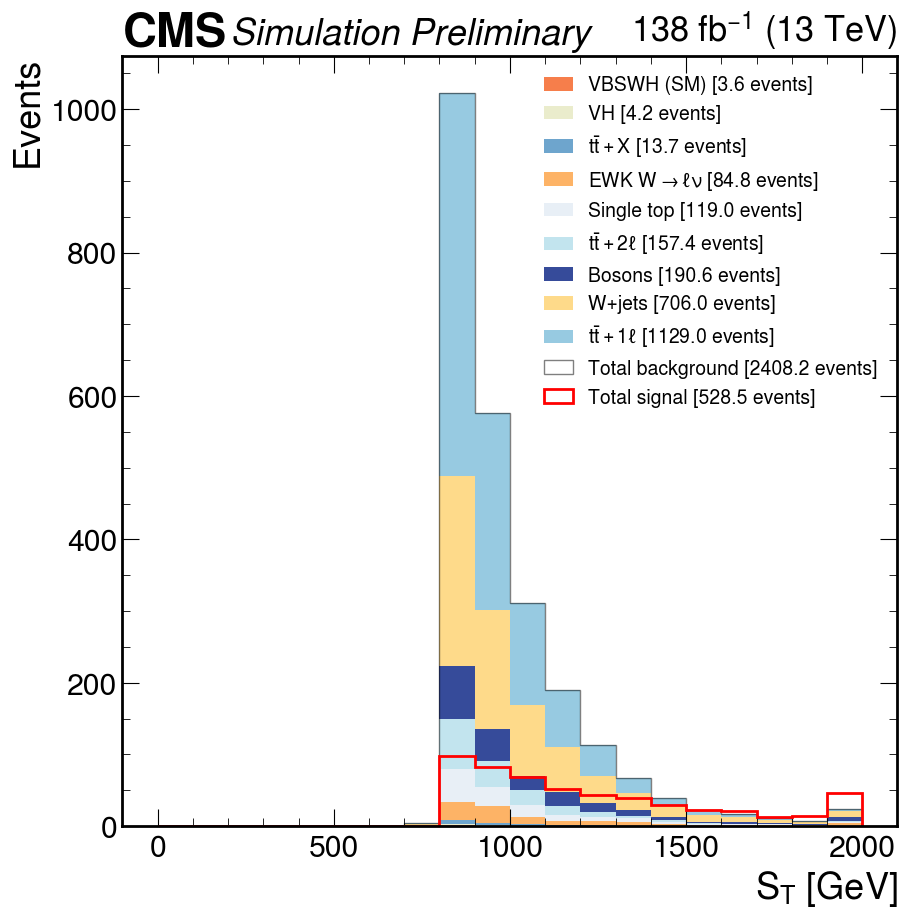

In [27]:
axes = vbswh.plot_sig_vs_bkg(
    "ST", np.linspace(0, 2000, 21), 
    selection="M_jj > 1500 and abs(deta_jj) > 5", x_label="$S_T$ [GeV]",
    stacked=True
);

In [28]:
vbswh.fom_scan(
    "ST", [1000, 1100, 1200, 1300, 1400, 1500, 1600, 1650, 1700, 1800], operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5,528.5043713880859,2408.181228552525,10.769709785877325
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1000,348.14726476630915,803.5744798717108,12.281457778594842
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1100,279.9566690480726,491.6808066201549,12.625517549413132
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1200,228.18658124841488,301.67849587670975,13.137657169405776
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,184.82534651524094,188.56986731336784,13.459390121130426
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1400,145.70972106669828,120.88903103246889,13.25241656106673
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1500,116.40280723042338,81.4211224015758,12.900154498856248
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1600,94.15685072448954,58.745284987783734,12.284724367983056
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1650,83.48118292663176,49.75461058936153,11.835099912508785
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1700,73.33844268517862,42.22326

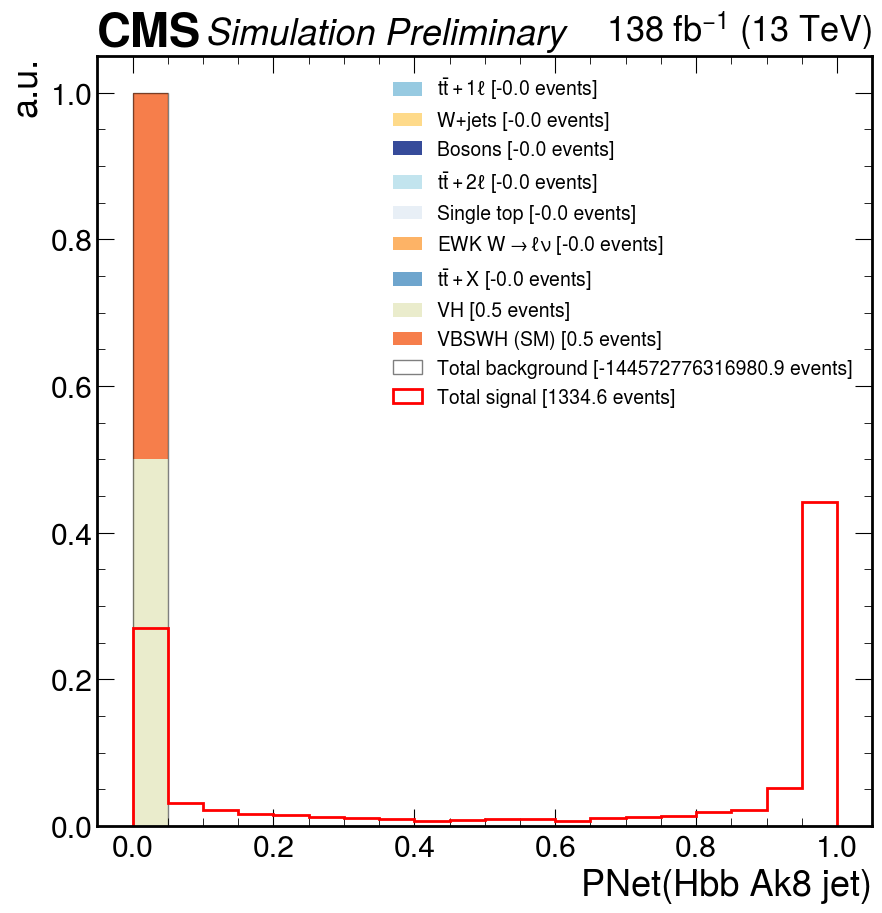

In [29]:
vbswh.plot_sig_vs_bkg(
    "hbbjet_score", np.linspace(0, 1.0, 21), 
#     selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300", 
    x_label="PNet(Hbb Ak8 jet)",
    stacked=True,
    norm=True
);

In [30]:
vbswh.fom_scan(
    "hbbjet_score", np.linspace(0.91, 0.99, 9), operator=">", 
    base_selection="M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300"
)

sel,sig,bkg,fom
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300,184.82534651524094,188.56986731336784,13.459390121130426
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.91,97.02643154321149,15.642348167314896,24.532346211417572
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.92,95.76854824816733,14.083829244643642,25.51893399146051
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.93,93.65471137744203,12.825282275677576,26.151473467488973
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.9400000000000001,91.9432348703586,11.64476589718248,26.943524075036503
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.95,88.50938689361165,10.190277654964724,27.726581268972364
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.96,85.90896640526361,8.596597838261955,29.300510616338016
M_jj > 1500 and abs(deta_jj) > 5 and ST > 1300 and hbbjet_score > 0.97,81.58389317036139,6.748835905392692,3